In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [42]:
csv_path='/content/drive/MyDrive/IRMAI/test.csv'

In [43]:
data=pd.read_csv(csv_path)

In [44]:
data.head()

,Trade_ID,Timestamp,Stock_Symbol,Price,Volume
0,6,2024-02-19 10:25:00,AAPL,152.5,130
1,7,2024-02-19 10:30:00,MSFT,300.0,190
2,8,2024-02-19 10:35:00,AAPL,153.0,110
3,9,2024-02-19 10:40:00,MSFT,299.5,170
4,10,2024-02-19 10:45:00,AAPL,152.8,160


In [45]:
##Installing the Driver
!pip install neo4j

In [46]:
##Importing the Graph Database
from neo4j import GraphDatabase

URI = "neo4j+s://fcc40631.databases.neo4j.io"
USERNAME = "neo4j"
PASSWORD = "4wiyIAjLKMeyl7egS7JY3NrvT20hu2Y8hAYM-4IZFY4"

driver=GraphDatabase.driver(URI, auth=(USERNAME, PASSWORD))

def test_connection(tx):
  res = tx.run('MATCH (n) RETURN COUNT(n) as node_count')
  return res.single()['node_count']

##Try o run the test query
with driver.session() as session:
  result = session.read_transaction(test_connection)
  print(result)

<ipython-input-46-3bff1a6650d0>:16: DeprecationWarning: read_transaction has been renamed to execute_read
  result = session.read_transaction(test_connection)


5


In [47]:
##This signify that the connection to the graph database has been established

In [48]:
def insert_trade(tx,symbol,timestamp,price,volume):
  query = """
    MERGE (t:Trade {symbol: $symbol, timestamp: $timestamp})
    SET t.price = $price, t.volume = $volume;
    """

  tx.run(query, symbol=symbol, timestamp=timestamp, price=price, volume=volume)



In [49]:
with driver.session() as session:
  for index, row in data.iterrows():
    session.write_transaction(insert_trade, row['Stock_Symbol'], row['Timestamp'], row['Price'], row['Volume'])

<ipython-input-49-9fa8bf52e685>:3: DeprecationWarning: write_transaction has been renamed to execute_write
  session.write_transaction(insert_trade, row['Stock_Symbol'], row['Timestamp'], row['Price'], row['Volume'])


In [50]:
with driver.session() as session:
  result = session.read_transaction(test_connection)
  print(result)

<ipython-input-50-807ce57ff5ba>:2: DeprecationWarning: read_transaction has been renamed to execute_read
  result = session.read_transaction(test_connection)


100


In [51]:
##The upper number 5 signify that the data is insertd into the Graph Database

In [52]:
def create_relationships(tx, query):
    tx.run(query)

next_trade_query = """
MATCH (t1:Trade), (t2:Trade)
WHERE t1.symbol = t2.symbol AND t1.timestamp < t2.timestamp
WITH t1, t2 ORDER BY t2.timestamp ASC
WITH t1, head(collect(t2)) AS next_trade
MERGE (t1)-[:NEXT_TRADE]->(next_trade);
"""

similar_trade_query = """
MATCH (t1:Trade), (t2:Trade)
WHERE t1.symbol = t2.symbol
AND abs(t1.price - t2.price) < 1.0
AND abs(t1.volume - t2.volume) < 100
AND t1.timestamp < t2.timestamp
MERGE (t1)-[:SIMILAR_TRADE]->(t2);
"""

# Run queries
with driver.session() as session:
    session.execute_write(create_relationships, next_trade_query)
    session.execute_write(create_relationships, similar_trade_query)

print("Relationships created successfully!")


Relationships created successfully!


In [59]:
def run_gap_analysis(tx, query):
    result = tx.run(query)
    return [record.data() for record in result]

missing_trades_query = """
MATCH (t1:Trade)-[:NEXT_TRADE]->(t2:Trade)
WHERE duration.between(
  datetime(apoc.date.convertFormat(t1.timestamp, 'yyyy-MM-dd HH:mm:ss', "yyyy-MM-dd'T'HH:mm:ss")),
  datetime(apoc.date.convertFormat(t2.timestamp, 'yyyy-MM-dd HH:mm:ss', "yyyy-MM-dd'T'HH:mm:ss"))
).minutes > 4
RETURN t1.symbol, t1.timestamp AS last_trade, t2.timestamp AS next_trade,
       duration.between(
         datetime(apoc.date.convertFormat(t1.timestamp, 'yyyy-MM-dd HH:mm:ss', "yyyy-MM-dd'T'HH:mm:ss")),
         datetime(apoc.date.convertFormat(t2.timestamp, 'yyyy-MM-dd HH:mm:ss', "yyyy-MM-dd'T'HH:mm:ss"))
       ) AS gap_duration;


"""

price_jump_query = """
MATCH (t1:Trade)-[:NEXT_TRADE]->(t2:Trade)
WHERE abs(t2.price - t1.price) > 5.0
RETURN t1.symbol, t1.timestamp, t1.price, t2.timestamp, t2.price,
       abs(t2.price - t1.price) AS price_change;
"""

with driver.session() as session:
    missing_trades = session.execute_read(run_gap_analysis, missing_trades_query)
    price_jumps = session.execute_read(run_gap_analysis, price_jump_query)

print(" Missing Trades Detected:", missing_trades)
print(" Unusual Price Jumps:", price_jumps)


 Missing Trades Detected: [{'t1.symbol': 'AAPL', 'last_trade': '2024-02-19 10:00:00', 'next_trade': '2024-02-19 10:05:00', 'gap_duration': Duration(months=0, days=0, seconds=300, nanoseconds=0)}, {'t1.symbol': 'AAPL', 'last_trade': '2024-02-19 10:05:00', 'next_trade': '2024-02-19 10:15:00', 'gap_duration': Duration(months=0, days=0, seconds=600, nanoseconds=0)}, {'t1.symbol': 'MSFT', 'last_trade': '2024-02-19 10:10:00', 'next_trade': '2024-02-19 10:20:00', 'gap_duration': Duration(months=0, days=0, seconds=600, nanoseconds=0)}, {'t1.symbol': 'AAPL', 'last_trade': '2024-02-19 10:15:00', 'next_trade': '2024-02-19 10:25:00', 'gap_duration': Duration(months=0, days=0, seconds=600, nanoseconds=0)}, {'t1.symbol': 'MSFT', 'last_trade': '2024-02-19 10:20:00', 'next_trade': '2024-02-19 10:30:00', 'gap_duration': Duration(months=0, days=0, seconds=600, nanoseconds=0)}, {'t1.symbol': 'AAPL', 'last_trade': '2024-02-19 10:25:00', 'next_trade': '2024-02-19 10:35:00', 'gap_duration': Duration(months=

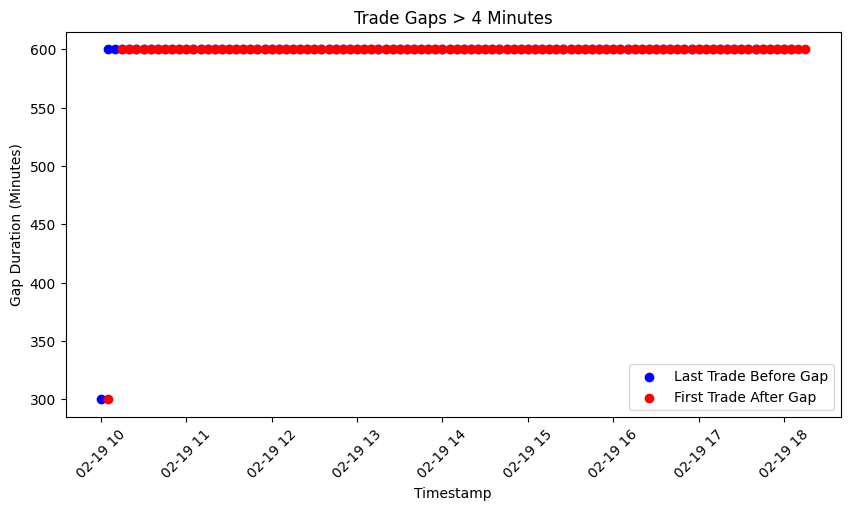

No unusual price jumps detected.


In [61]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

# Convert missing trades data into a DataFrame
missing_trades_df = pd.DataFrame(missing_trades)

if not missing_trades_df.empty:
    missing_trades_df["last_trade"] = pd.to_datetime(missing_trades_df["last_trade"])
    missing_trades_df["next_trade"] = pd.to_datetime(missing_trades_df["next_trade"])
    missing_trades_df["gap_duration"] = missing_trades_df["gap_duration"].apply(lambda x: x[2])

    # Plot missing trades as gaps
    plt.figure(figsize=(10, 5))
    plt.scatter(missing_trades_df["last_trade"], missing_trades_df["gap_duration"], label="Last Trade Before Gap", color='blue')
    plt.scatter(missing_trades_df["next_trade"], missing_trades_df["gap_duration"], label="First Trade After Gap", color='red')
    plt.xlabel("Timestamp")
    plt.ylabel("Gap Duration (Minutes)")
    plt.title("Trade Gaps > 4 Minutes")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

else:
    print("No missing trades detected.")

# Convert price jumps data into a DataFrame
price_jumps_df = pd.DataFrame(price_jumps)

if not price_jumps_df.empty:
    price_jumps_df["timestamp"] = pd.to_datetime(price_jumps_df["timestamp"])
    price_jumps_df["next_timestamp"] = pd.to_datetime(price_jumps_df["next_timestamp"])

    # Plot price changes
    plt.figure(figsize=(10, 5))
    plt.plot(price_jumps_df["timestamp"], price_jumps_df["price"], label="Price Before Jump", marker="o", linestyle="-")
    plt.scatter(price_jumps_df["next_timestamp"], price_jumps_df["price_change"], label="Price Jump", color="red")
    plt.xlabel("Timestamp")
    plt.ylabel("Price")
    plt.title("Unusual Price Jumps (> $5)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

else:
    print("No unusual price jumps detected.")


In [62]:
def run_query(tx, query):
    result = tx.run(query)
    return [record.data() for record in result]

volume_deviation_query = """
MATCH (t:Trade)
WHERE t.volume < 500 OR t.volume > 2000
RETURN t.symbol, t.timestamp, t.volume;
"""

price_deviation_query = """
MATCH (t1:Trade)-[:NEXT_TRADE]->(t2:Trade)
WHERE abs(t2.price - t1.price) > 3.0
RETURN t1.symbol, t1.timestamp AS trade_time, t1.price, t2.timestamp AS next_trade_time, t2.price, abs(t2.price - t1.price) AS price_change;
"""

with driver.session() as session:
    volume_deviations = session.execute_read(run_query, volume_deviation_query)
    price_deviations = session.execute_read(run_query, price_deviation_query)

print("Volume Deviations:", volume_deviations)
print("Price Deviations:", price_deviations)



Volume Deviations: [{'t.symbol': 'AAPL', 't.timestamp': '2024-02-19 10:00:00', 't.volume': 100}, {'t.symbol': 'AAPL', 't.timestamp': '2024-02-19 10:05:00', 't.volume': 150}, {'t.symbol': 'MSFT', 't.timestamp': '2024-02-19 10:10:00', 't.volume': 200}, {'t.symbol': 'AAPL', 't.timestamp': '2024-02-19 10:15:00', 't.volume': 120}, {'t.symbol': 'MSFT', 't.timestamp': '2024-02-19 10:20:00', 't.volume': 180}, {'t.symbol': 'AAPL', 't.timestamp': '2024-02-19 10:25:00', 't.volume': 130}, {'t.symbol': 'MSFT', 't.timestamp': '2024-02-19 10:30:00', 't.volume': 190}, {'t.symbol': 'AAPL', 't.timestamp': '2024-02-19 10:35:00', 't.volume': 110}, {'t.symbol': 'MSFT', 't.timestamp': '2024-02-19 10:40:00', 't.volume': 170}, {'t.symbol': 'AAPL', 't.timestamp': '2024-02-19 10:45:00', 't.volume': 160}, {'t.symbol': 'MSFT', 't.timestamp': '2024-02-19 10:50:00', 't.volume': 210}, {'t.symbol': 'AAPL', 't.timestamp': '2024-02-19 10:55:00', 't.volume': 140}, {'t.symbol': 'MSFT', 't.timestamp': '2024-02-19 11:00:00